# 0.0. IMPORTS

In [66]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
import random
import pickle
import warnings
warnings.filterwarnings('ignore')
import json
import requests
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from IPython.display import Image
from scipy import stats as ss
#from html import HTML
from IPython.core.display import display, HTML
from tabulate import tabulate
from boruta import BorutaPy
from flask import Flask, request, Response
#from rossman.Rossman import Rossman

from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [67]:
# define parâmetros de exibição de gráficos no Notebook. Fonte: 
# (https://comunidadeds.slack.com/archives/C019G4N0CF5/p1639584486292800?thread_ts=1639583542.291900&cid=C019G4N0CF5)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [28, 8]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    display(HTML("<style>.jp-Cell { width: 60% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

# calculando Cramér's V, onde 0 = sem correlação, 1 = correlação total
def cramers_v (x,y):

    # making a cross-tabulation table (contingency table) that shows the frequency of two groups of data
    ct = pd.crosstab(x,y).values # transforms table to array object (easy to perform some operations, eg. sum, dimensions)
    
    totals = ct.sum() # sum all the values of the cross-tabulation table (now an array)
    rows, cols = ct.shape # get array's dimensions (index, rows) and number of elements in each dimension (cols)

    chi2 = stats.chi2_contingency(ct)[0] # returns a list with chi2, p-value, degree of freedom and expected values. We only want the first element (chi2).


    # Bias Correction - source: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    chi2_corr = max(0, (chi2/totals - ( (cols-1)*(rows-1) )/(totals-1) ) )

    cols_corr = cols - pow( (cols-1),2 )/(totals-1)
    rows_corr = rows - pow( (rows-1),2 )/(totals-1)

    v = np.sqrt( chi2_corr/min((cols_corr - 1), (rows_corr - 1) ) )

    return v

def half_heatmap (data, width = 10, height = 8):

    # Preparing a mask to show an empty upper triangle on the heatmap
    mask = np.zeros_like(data) # return an array of zeros of same shape and type of df
    mask[np.triu_indices_from(mask)] = True # return indices of upper triangle of array and assign 'True' boolean value to this positions

    # Plotting heatmap
    plt.figure(figsize = (width, height))
    
    with sns.axes_style("dark"):
        ax = sns.heatmap(data, mask = mask,vmin = 0., vmax = 1, square = True, annot = True) # where mask = True data will not be shown.
    
    plt.show();

    return None

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame( {
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n KFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)] 

        # training and validation datasets
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                        'MAE Cross-Validation': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE Cross-Validation': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE Cross-Validation': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)
                        }, index=[0])   

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [6]:
path = str(Path.cwd().parents[0] / "telegram_api")
path_train = path + '/' + 'train.csv'
path_stores = path + '/' + 'store.csv'

df_sales_raw = pd.read_csv(path_train, low_memory=False)
df_store_raw = pd.read_csv(path_stores, low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS

In [7]:
# copy data to prevent overwritting original data

df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
       'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# change columns names to snakecase format
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map (snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions 

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of colums: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of colums: 18


## 1.3. Data Types 

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA 

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA 

In [13]:
# competition_distance
# change NA for a much greater value (200000)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
# são os meses nos quais a loja está com a promoção ativa
# estratégia: coletar o mês atual da loja, transformar o mês em nome e verificar se esse nome do mês está na lista de meses
# da promoção da loja.

# cria um dicionário p/converter os meses numéricos em nomes
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# preenche os NA da coluna com 0, sem precisar atribuir (inplace)
df1['promo_interval'].fillna(0, inplace=True)

# cria coluna month_map a partir do mês da data atual da loja, convertendo conforme o dicionário acima
df1['month_map'] = df1['date'].dt.month.map(month_map)

# se o mês atual (month_map) está contido na lista de meses de promoção (promo_interval.split), a loja está em promoção (is_promo)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df1.sample(5).T

,459191,325019,808562,354356,344285
store,597,897,973,208,453
day_of_week,5,7,7,3,7
date,2014-05-16 00:00:00,2014-09-28 00:00:00,2013-07-07 00:00:00,2014-08-27 00:00:00,2014-09-07 00:00:00
sales,4508,0,0,2523,4474
customers,706,0,0,358,598
open,1,0,0,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,c,d,c,a


## 1.6. Change Types 

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)   

## 1.7. Descriptive Statistics

In [18]:
# splitting numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T #range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

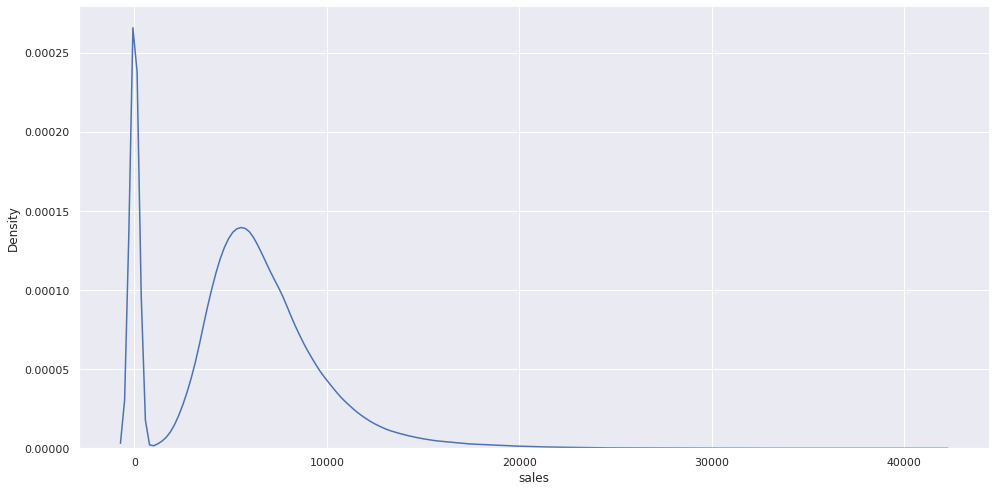

In [20]:
sns.displot(df1['sales'], kind='kde', height=7, aspect=2)

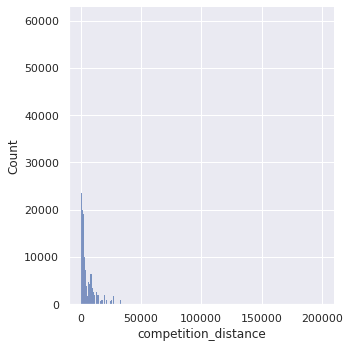

In [21]:
sns.displot(df1['competition_distance'], )

### 1.7.2. Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

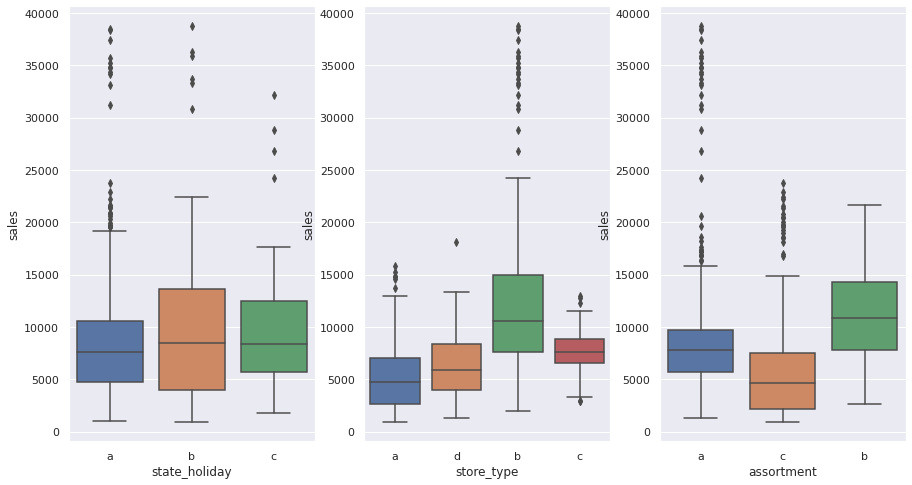

In [23]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & (df1['sales'] > 0) ]

plt.figure(figsize=(15, 8)) # plot dimensions

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1. Criação de Hipóteses

Pense como cada atributo de agente pode impactar o fenômeno estudado (vendas na loja)

### Mapa Mental de Hipóteses

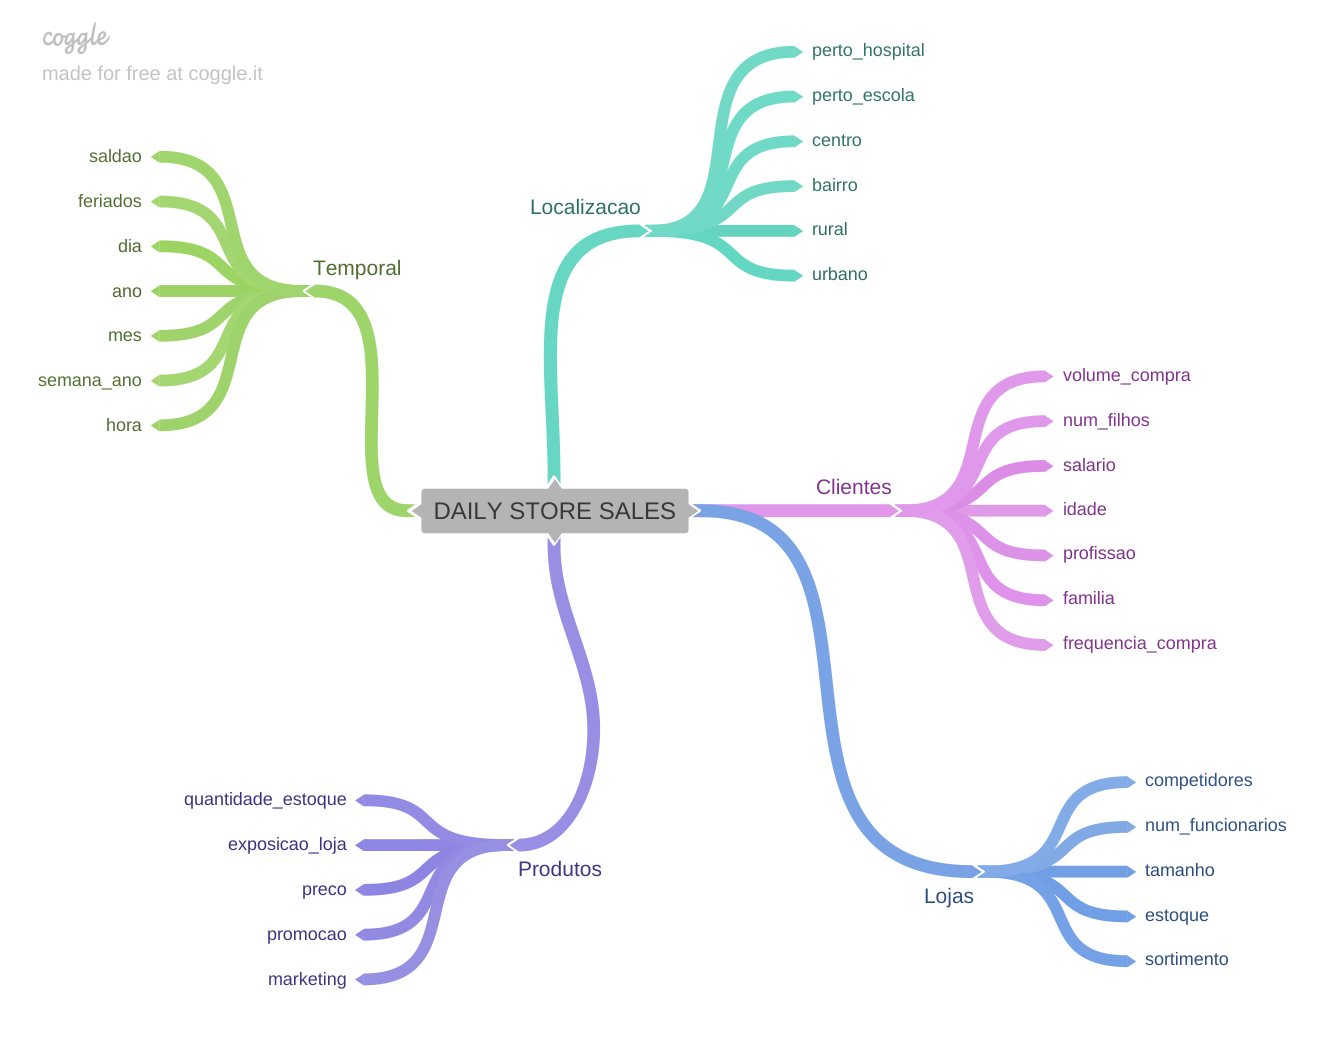

In [27]:
path = str(Path.cwd().parents[0] / "telegram_api")
path_mind_map = path + '/' + 'mind_map_hypothesis.png'

Image(path_mind_map)

### 2.1.1. Hipóteses de Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.1.2. Hipóteses de Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõem mais o produto na vitrine deveriam vender mais.

**3.** Lojas com produtos mais baratos deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com promoções agressivas (descontos maiores) deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses de Tempo

**1.** Lojas deveriam vender menos durante os feriados escolares.

**2.** Lojas deveriam vender mais no segundo semestre.

**3.** Lojas deveriam vender menos aos finais de semana.

**4.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas deveriam vender mais depois do dia 10.

## 2.2. Lista Final de Hipóteses (priorização)

(o foco são hipóteses para as quais já temos os dados necessários p/validar)

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas deveriam vender menos durante os feriados escolares.

**9.** Lojas deveriam vender mais no segundo semestre.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**12.** Lojas deveriam vender mais ao longo dos anos.

**13.** Lojas deveriam vender mais depois do dia 10.

## 2.3. Feature Engineering

In [28]:
# obtendo as variáveis necessárias para testar as hipóteses

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment 
# na descrição dos dados no Kaggle explica quais são os tipos de assortment
df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. Filtragem de Variáveis

Retirar variáveis que não estarão disponíveis no momento da previsão. Levar em conta o contexto de negócio.

In [29]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [30]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ]

## 3.2. Seleção das Colunas

In [31]:
# 'open' será sempre 1 depois que dropamos as linhas com 'open' = 0
# dropamos colunas auxiliares

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Análise Exploratória dos Dados - EDA

In [32]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

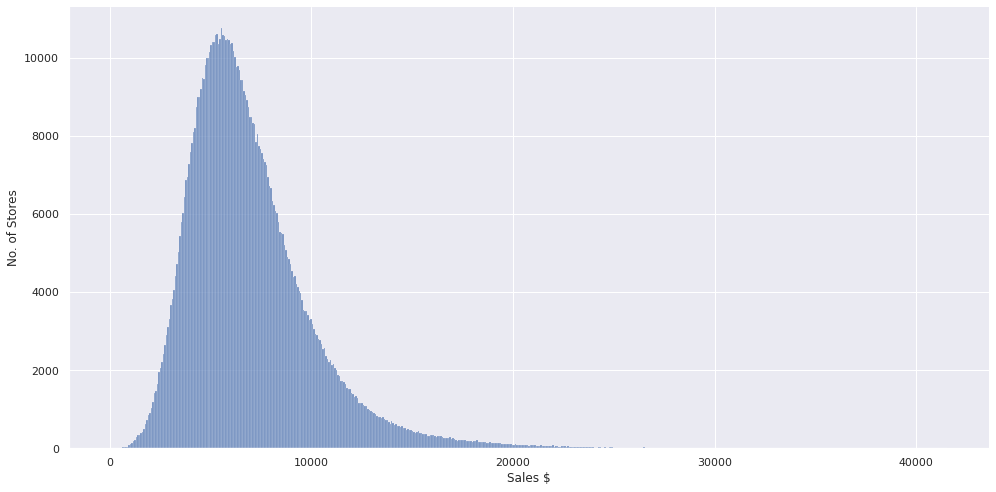

In [33]:
fig = sns.displot(df4['sales'], kde=False, height=7, aspect=2) # retorna um objeto FacetGrid
fig.set_axis_labels('Sales $', 'No. of Stores')

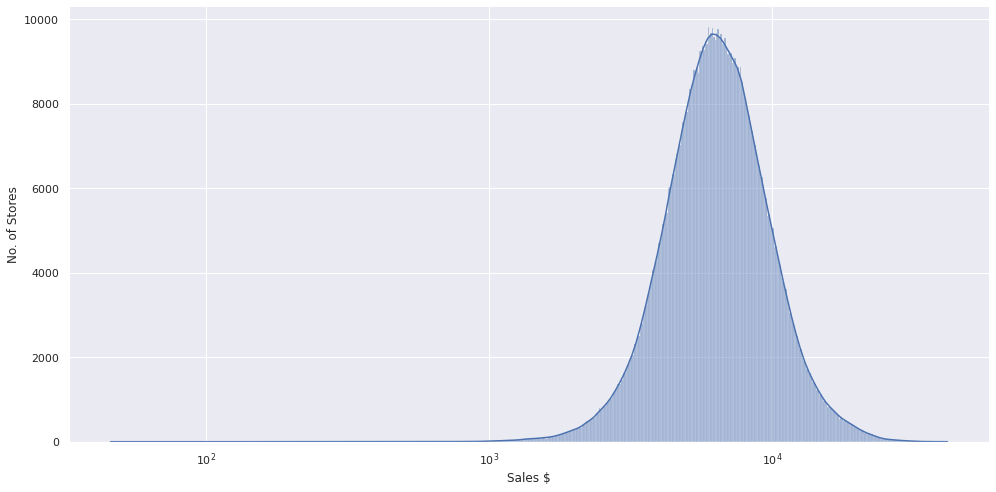

In [34]:
fig = sns.displot(df4['sales'], kde=True, log_scale=True, height=7, aspect=2) # retorna um objeto FacetGrid
fig.set_axis_labels('Sales $', 'No. of Stores')

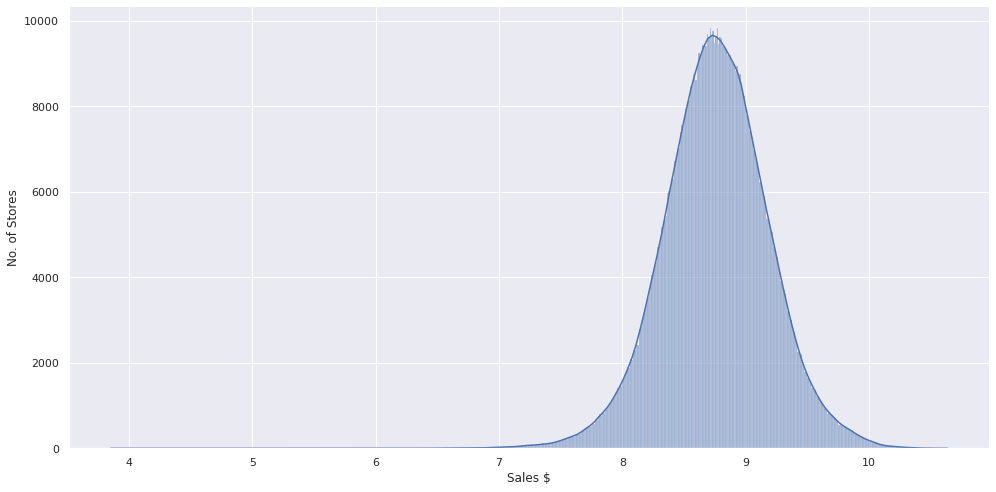

In [35]:
fig = sns.displot(np.log1p(df4['sales']), kde=True, height=7, aspect=2) # retorna um objeto FacetGrid
fig.set_axis_labels('Sales $', 'No. of Stores')

### 4.1.2. Variável Numérica

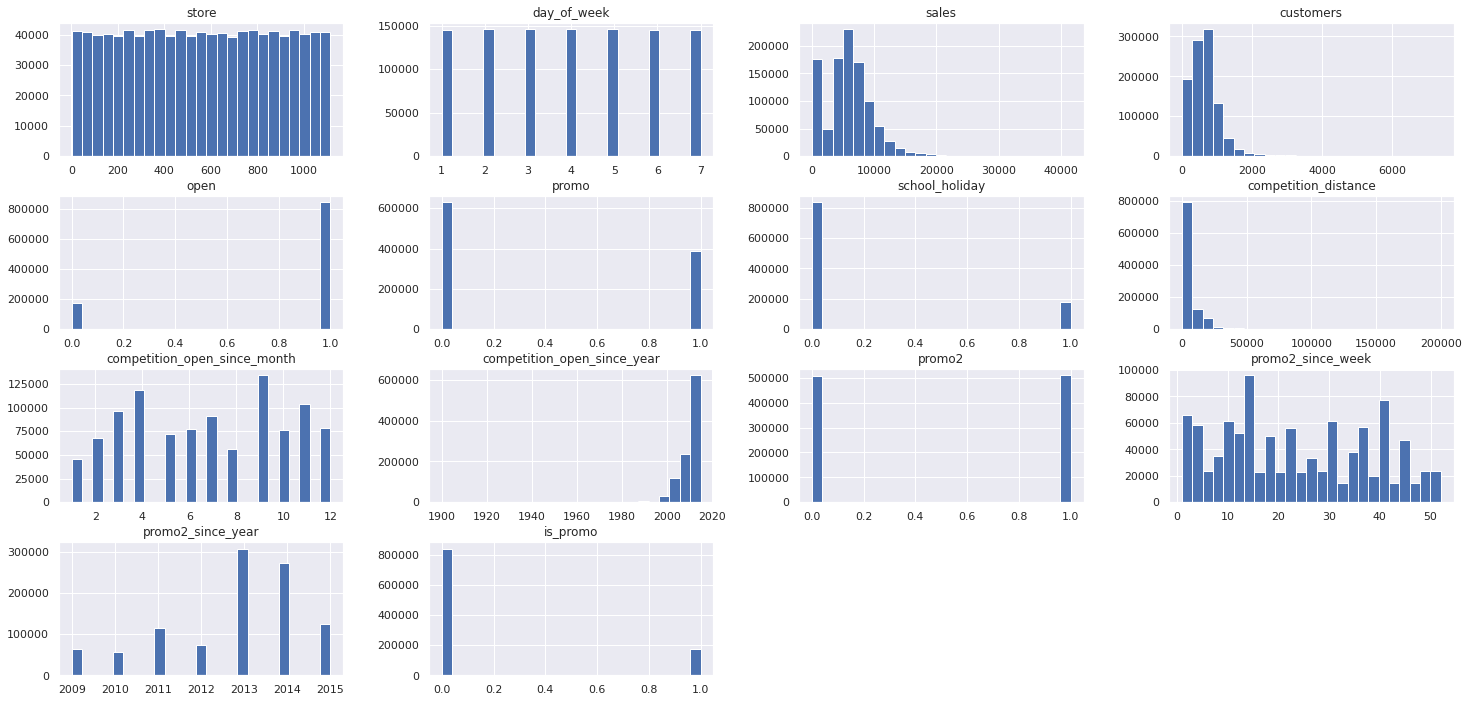

In [36]:
num_attributes.hist(bins=25);

### 4.1.3. Variável Categórica

<AxesSubplot:xlabel='sales', ylabel='Density'>

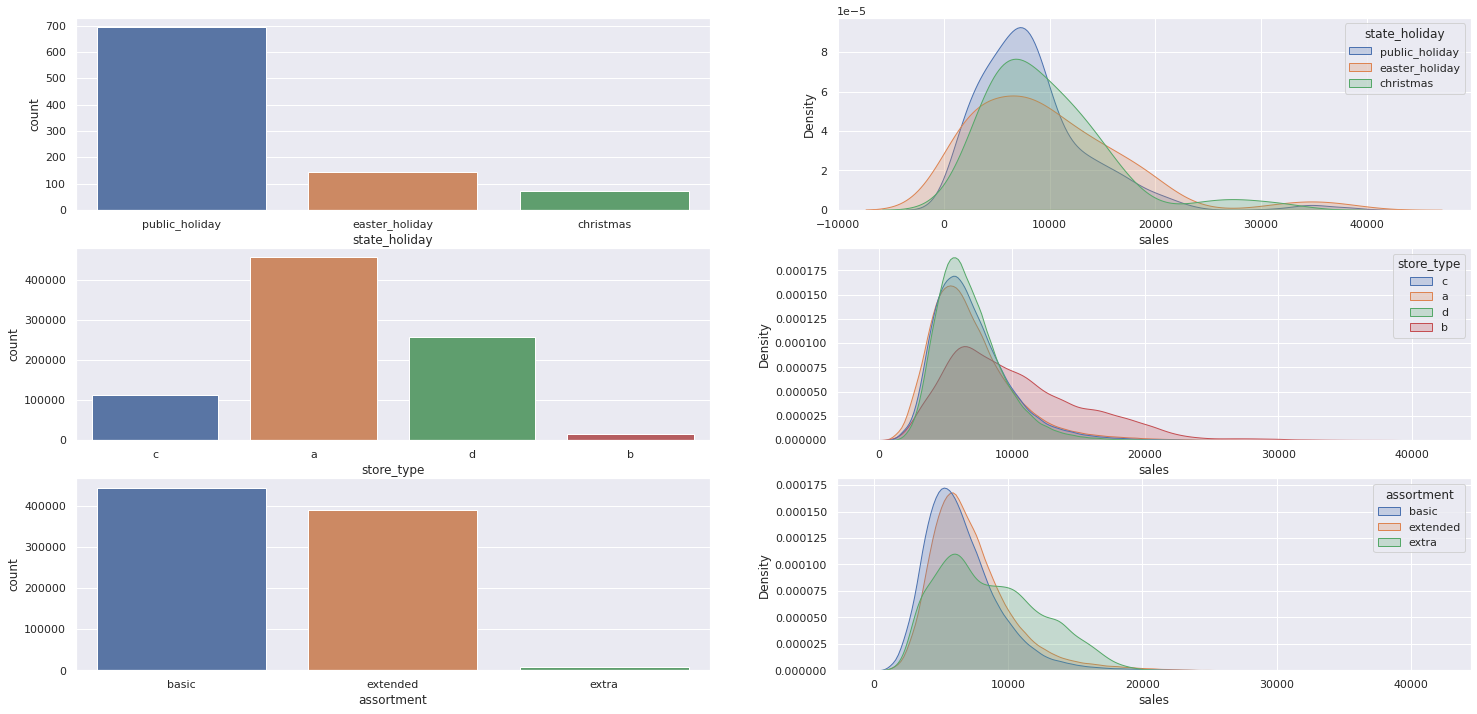

In [37]:
# state_holiday
# qual é o feriado com maior impacto nas vendas?

plt.subplot(3,2,1) # cria uma matriz com 1 linha e 2 colunas. Plota o gráfico abaixo na coluna 1
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3,2,2)
# sns.kdeplot(x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
# sns.kdeplot(x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
# sns.kdeplot(x=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

sns.kdeplot(x=df4[df4['state_holiday'] == 'public_holiday']['sales'], hue=a['state_holiday'], shade=True, warn_singular=False)
sns.kdeplot(x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], hue=a['state_holiday'], shade=True, warn_singular=False)
sns.kdeplot(x=df4[df4['state_holiday'] == 'christmas']['sales'], hue=a['state_holiday'], shade=True, warn_singular=False)

# store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(x=df4[df4['store_type'] == 'a']['sales'], hue=df4['store_type'], shade=True, warn_singular=False )
sns.kdeplot(x=df4[df4['store_type'] == 'b']['sales'], hue=df4['store_type'], shade=True, warn_singular=False )
sns.kdeplot(x=df4[df4['store_type'] == 'c']['sales'], hue=df4['store_type'], shade=True, warn_singular=False )
sns.kdeplot(x=df4[df4['store_type'] == 'd']['sales'], hue=df4['store_type'], shade=True, warn_singular=False )

# assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(x=df4[df4['assortment'] == 'extended']['sales'], hue=df4['assortment'], shade=True, warn_singular=False )
sns.kdeplot(x=df4[df4['assortment'] == 'basic']['sales'], hue=df4['assortment'], shade=True, warn_singular=False )
sns.kdeplot(x=df4[df4['assortment'] == 'extra']['sales'], hue=df4['assortment'], shade=True, warn_singular=False )

## 4.2. Análise Bivariada

### 1. Lojas com maior sortimento deveriam vender mais.
**Resposta**: FALSA. Lojas com MAIOR sortimento vendem MENOS.

<AxesSubplot:xlabel='year_week'>

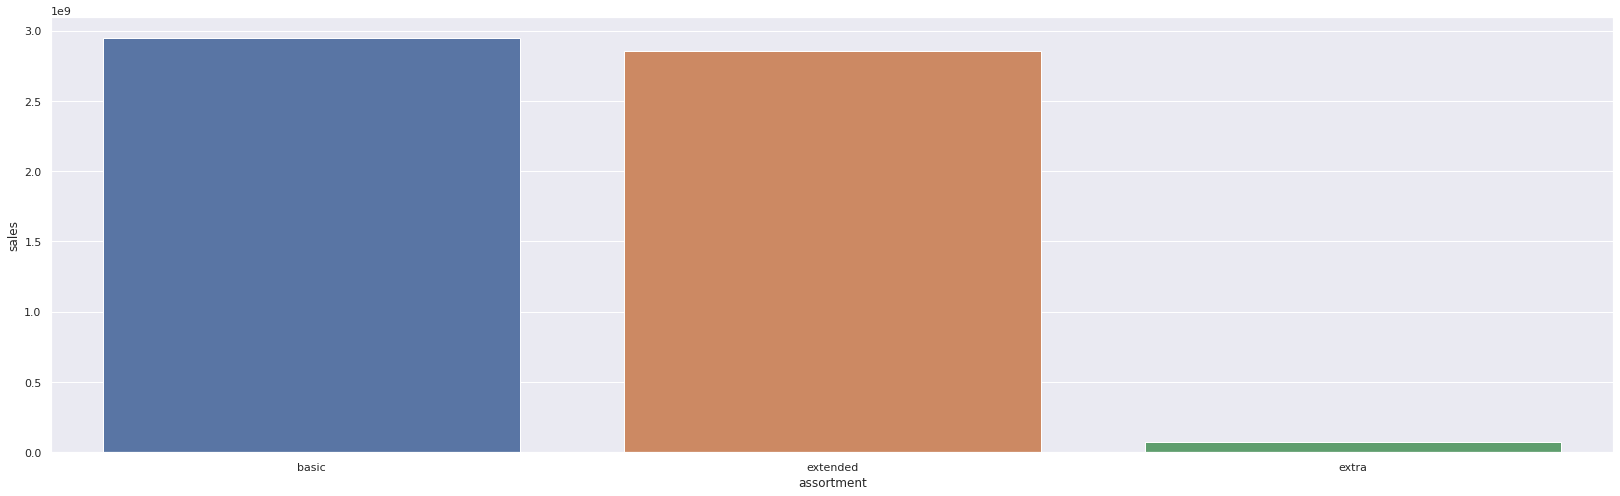

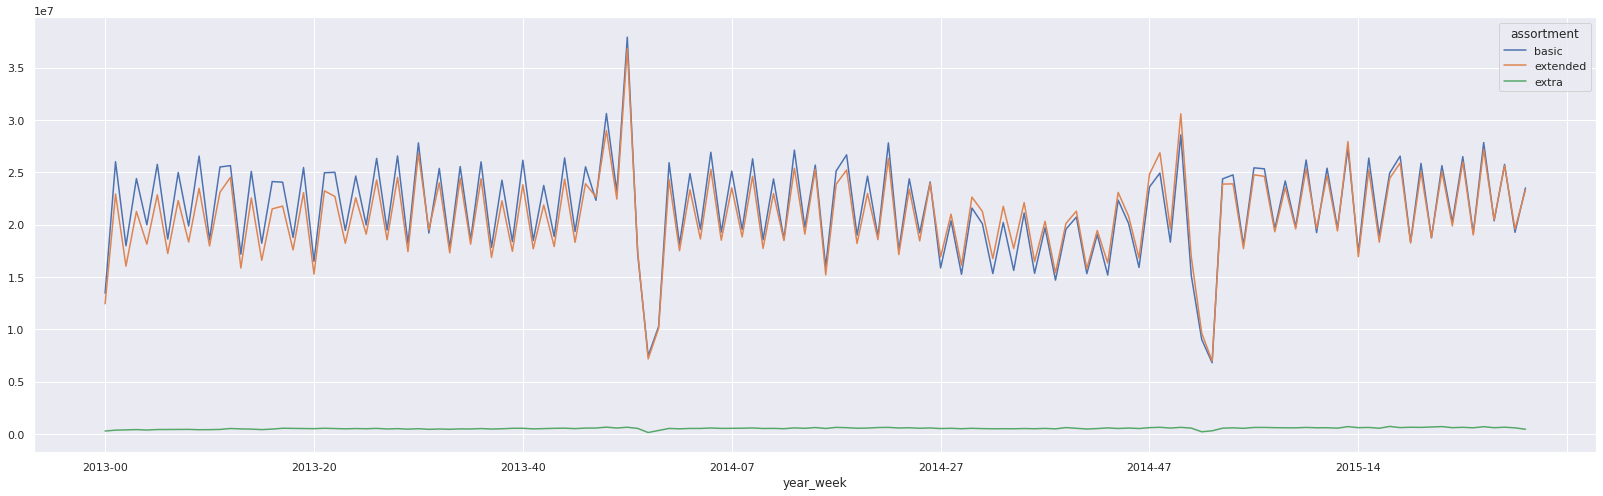

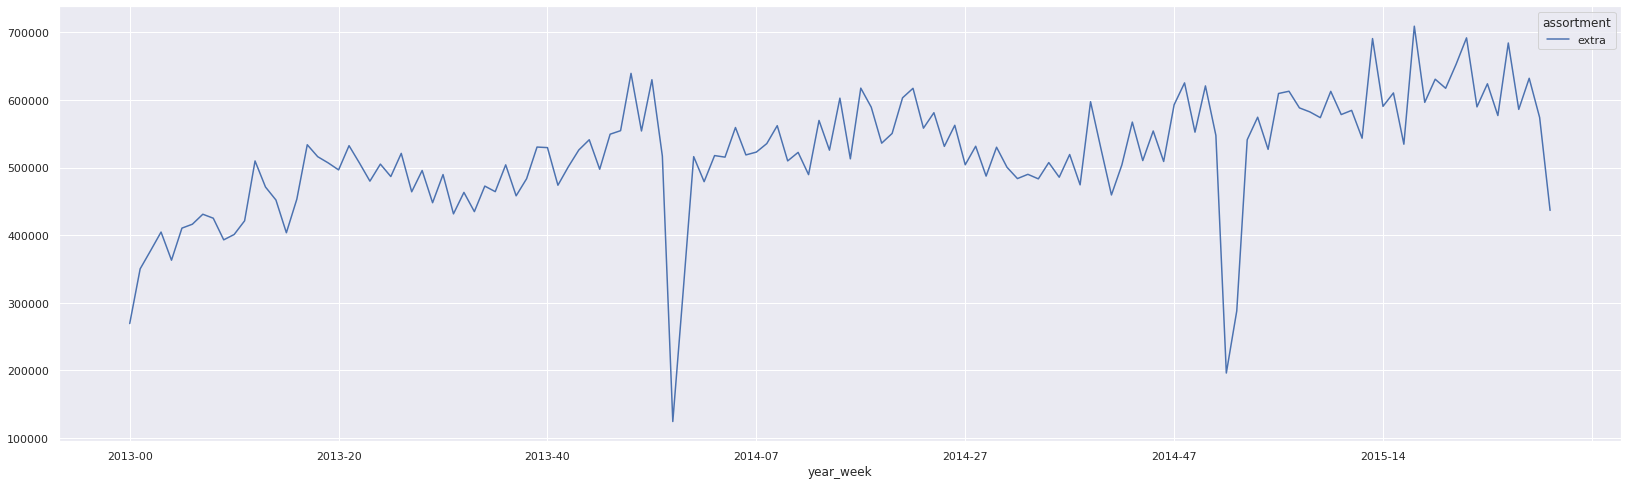

In [40]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

# será que o assortment 'extra' era melhor e agora piorou?
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot() # transforma os assortments em colunas e os 'year_week' em linhas

# como será o comportamento do assortment 'extra', dado que no gráfico anterior não pudemos enxergá-lo com clareza por causa da escala?
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 2. Lojas com competidores mais próximos deveriam vender menos.
**Resposta**: falsa. Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

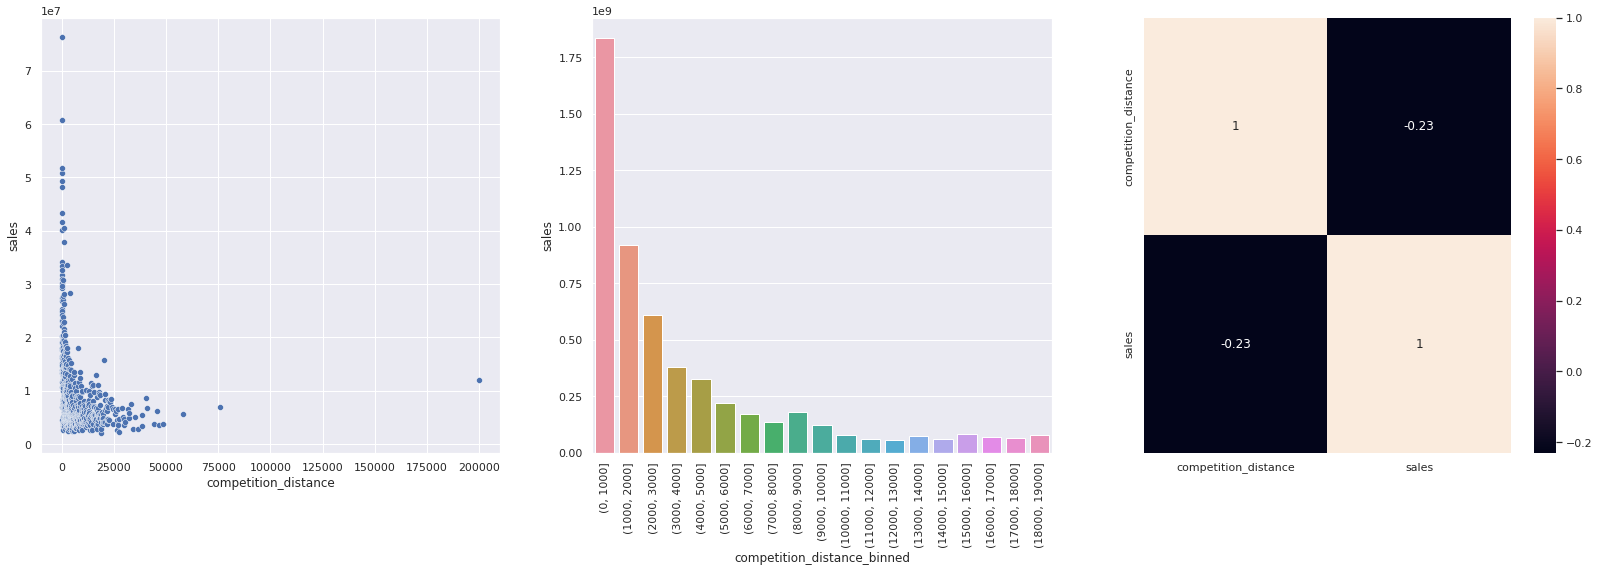

In [41]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data=aux1, x='competition_distance', y='sales')

# E se agrupássemos as distãncias por grupos de 1000 (bins)? Isso reduziria a granularidade do gráfico.
plt.subplot(1,3,2)
bins = list( np.arange(0, 20000, 1000) ) #limites arbitrários dos grupos
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90) # labels deste gráfico estavam sobrepostos. Vou rotacioná-los 90 graus.

# força da correlação de pearson - usaremos um heatmap
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 3. Lojas com competidores há mais tempo vendem mais.
**Resposta:** FALSA. Lojas com competidores há MAIS TEMPO vendem MENOS.

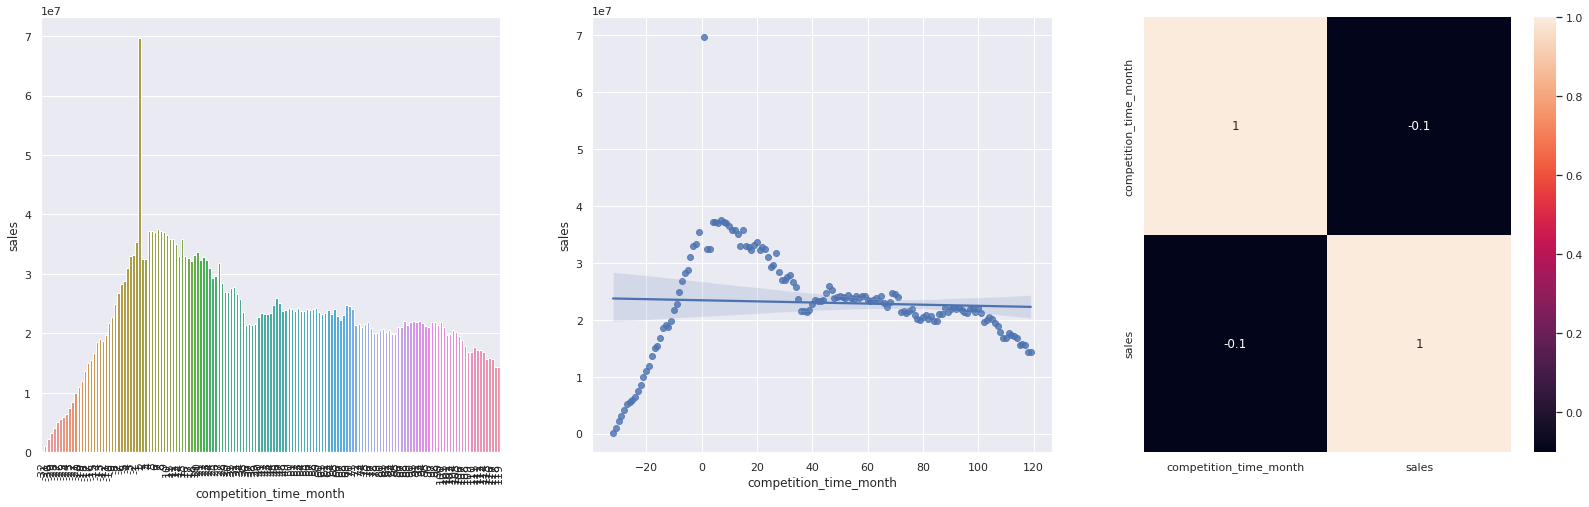

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0) ] # queremos competidores que não abriram no mesmo mês e têm menos de 120 meses.
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

# 'competition_time_month' < 0 significa que o competidor VAI ABRIR depois da data em que a loja Rossman foi registrada no sistema
# insight: quanto mais recente a competição, mais vendas a loja Rossman faz.

plt.subplot(1,3,2)
sns.regplot(data=aux2, x='competition_time_month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**Resposta:** FALSA. Elas vendem mais por determinado período após o início da promoção e, após, vendem menos.

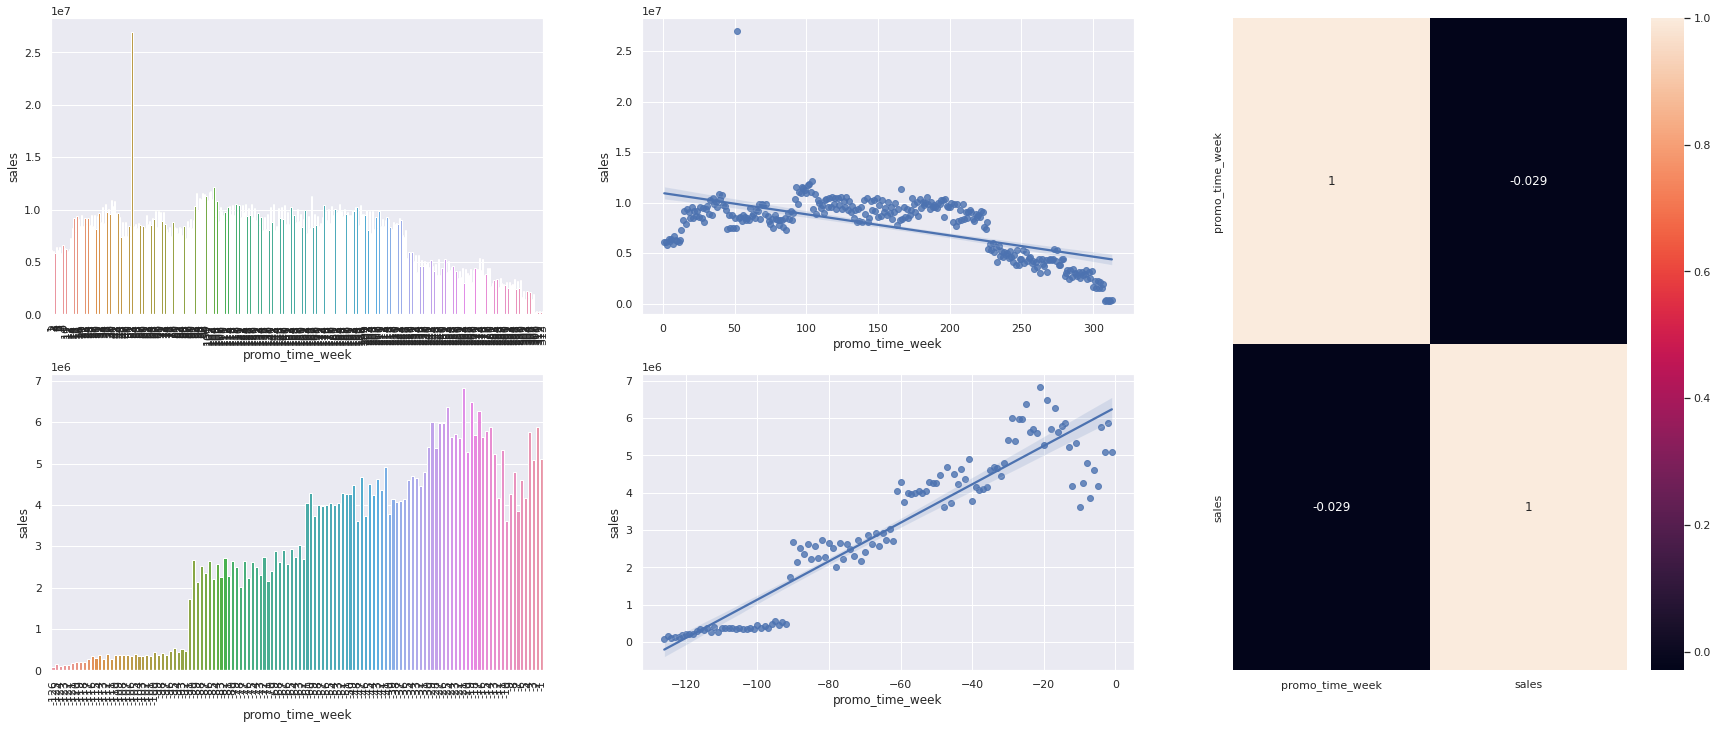

In [51]:
# 'promo_time_week' < 0 significa que a promoção estendida (promo2) VAI INICIAR no futuro.
# Ou seja, a promo estendida está mais próxima quanto mais próximo de zero. Abaixo de zero ela VAI começar. Acima de zero ela JÁ COMEÇOU.
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0] # está na promo estendida
aux3 = aux1[aux1['promo_time_week'] < 0] # está na promo regular

#figure(figsize=(20, 8))
grid = GridSpec(2,3) # cria uma grid com 2 linhas e 3 colunas
plt.subplots(figsize = (30, 12))


plt.subplot(grid[0,0])
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales'); # gráfico de regressão p/confirmar a tendência

plt.subplot(grid[1,0])
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True); # correlação - mostra se a feature é relevante p/o modelo (corr. forte)

### 5. Lojas com mais dias de promoção deveriam vender mais.

**Resposta:** vamos validar no próximo ciclo do CRISP, já que ela é bem parecida com a anterior.

### 6. Lojas com mais promoções consecutivas deveriam vender mais.
**Resposta:** FALSA. Lojas com promoção estendida (promo2) venderam menos.

In [47]:
# será que lojas que entraram na promoção estendida (promo2) venderam mais?
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


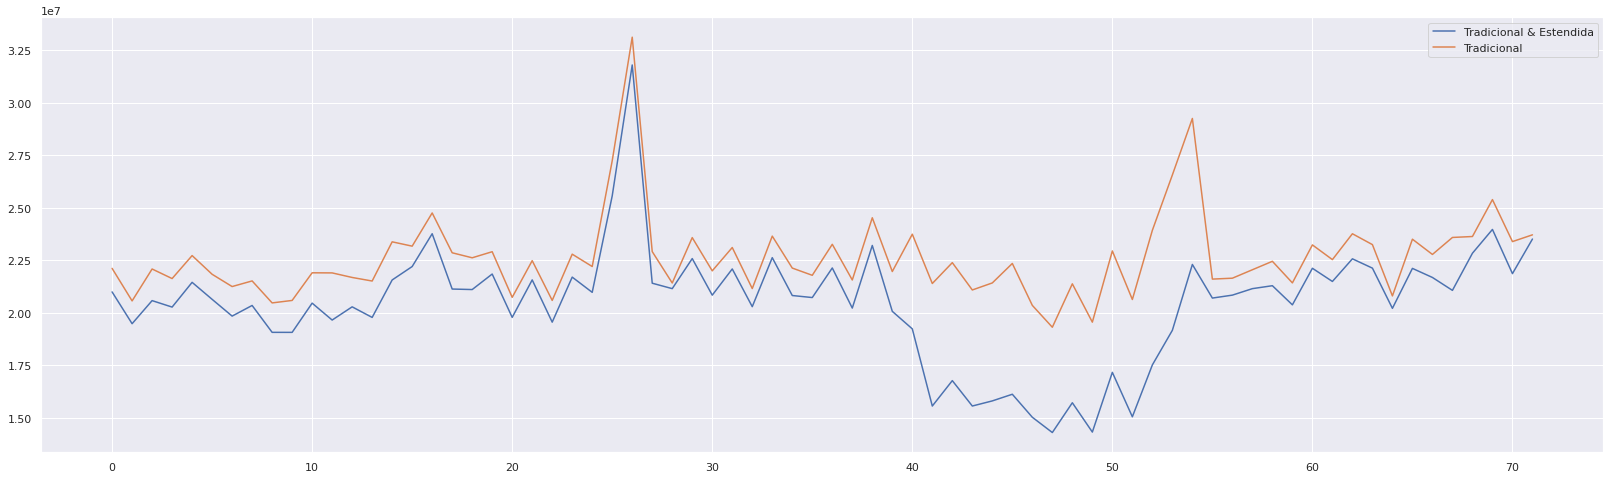

In [48]:
# como foi a performance ao longo do tempo das lojas que estavam nas duas promos?
aux1 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# como foi a performance ao longo do tempo das lojas que estavam apenas na promo?
aux2 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Estendida', 'Tradicional'])

### 7. Lojas deveriam vender menos durante os feriados escolares.
**Resposta:** FALSA. As lojas vendem menos nos feriados escolares ao considerar o total de vendas. Mas existem muito mais dias que não são feriados escolares. Ao ignorar a diferença de tamanho dos dois grupos, considerando a MÉDIA DIÁRIA DE VENDAS dos dois grupos, verificamos que as lojas vendem mais durante feriados escolares.

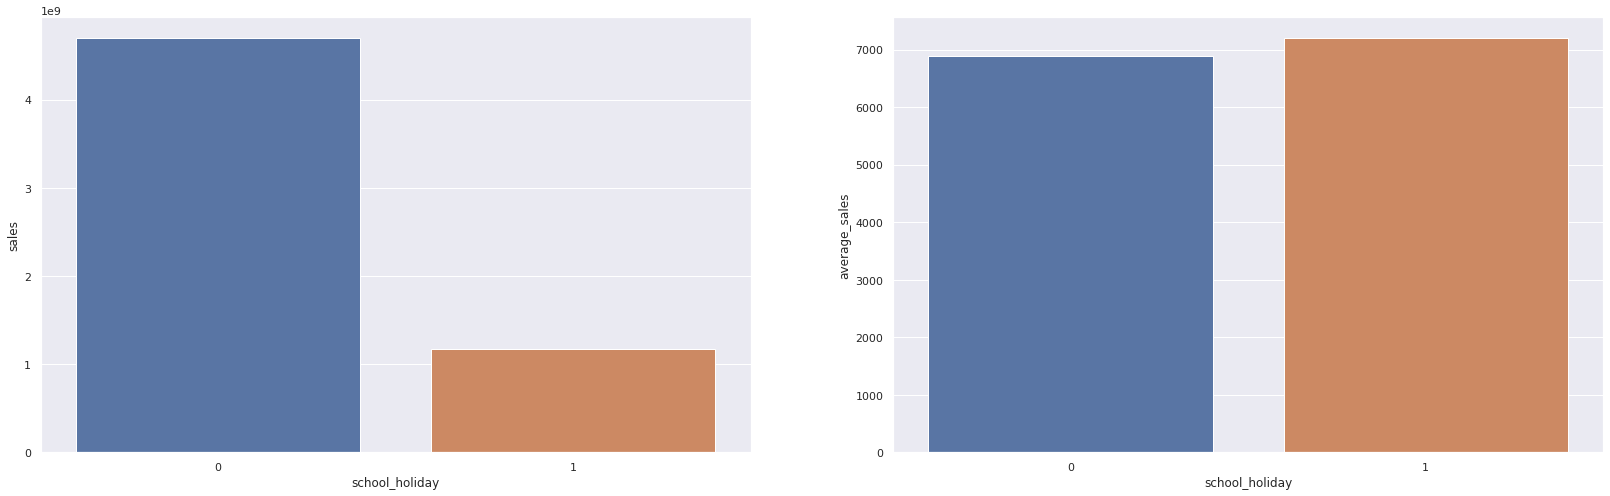

In [52]:
plt.subplot(1,2,1)
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data=aux, x='school_holiday', y='sales');

# mas existem muito mais dias que NÃO são school_holiday. Logo, o total de vendas
# será muito maior no grupo "não é school_holiday"
# um modo de ignorar o tamanho dos grupos é comparar a MÉDIA de vendas diárias de cada grupo
plt.subplot(1,2,2)
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux = aux.rename(columns={'sales':'average_sales'})
sns.barplot(data=aux, x='school_holiday', y='average_sales');

### 8. Lojas deveriam vender mais no segundo semestre.
**Resposta:** FALSA. As lojas vendem menos no segundo semestre, a partir do mês 07.

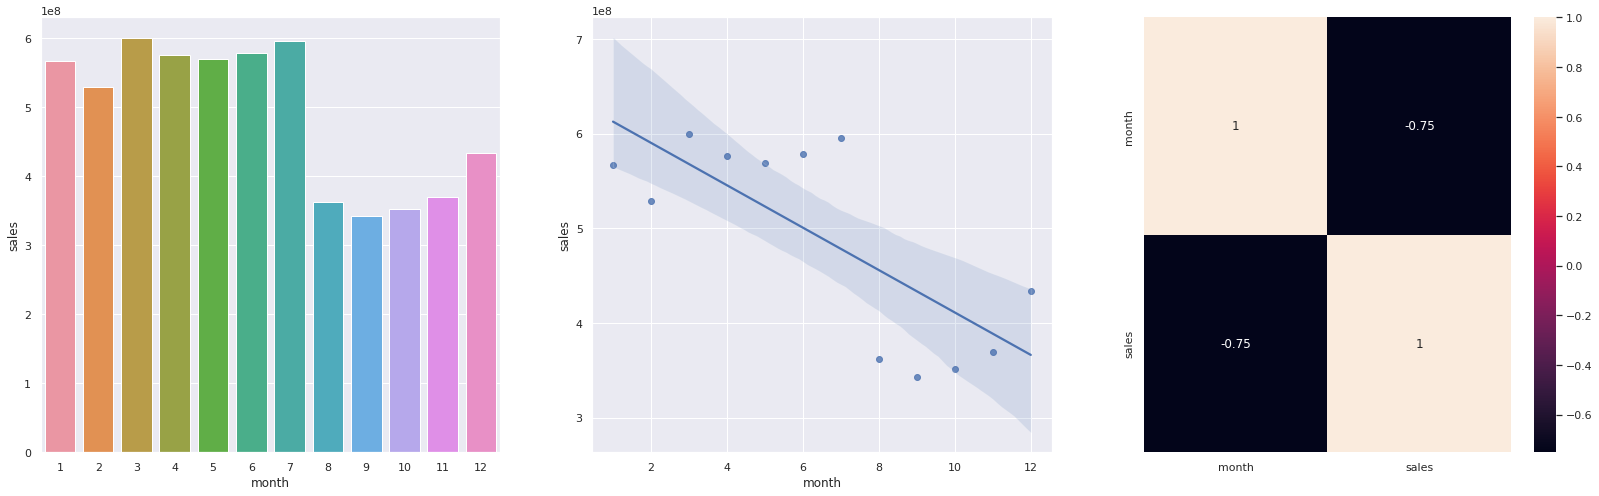

In [53]:
plt.subplot(1,3,1)
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(data=aux, x='month', y='sales');

# tendência
plt.subplot(1,3,2)
sns.regplot(data=aux, x='month', y='sales');

# correlação
plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 09. Lojas deveriam vender menos aos finais de semana.
**Resposta:** VERDADEIRA. As lojas vendem menos aos sábados e domingos.

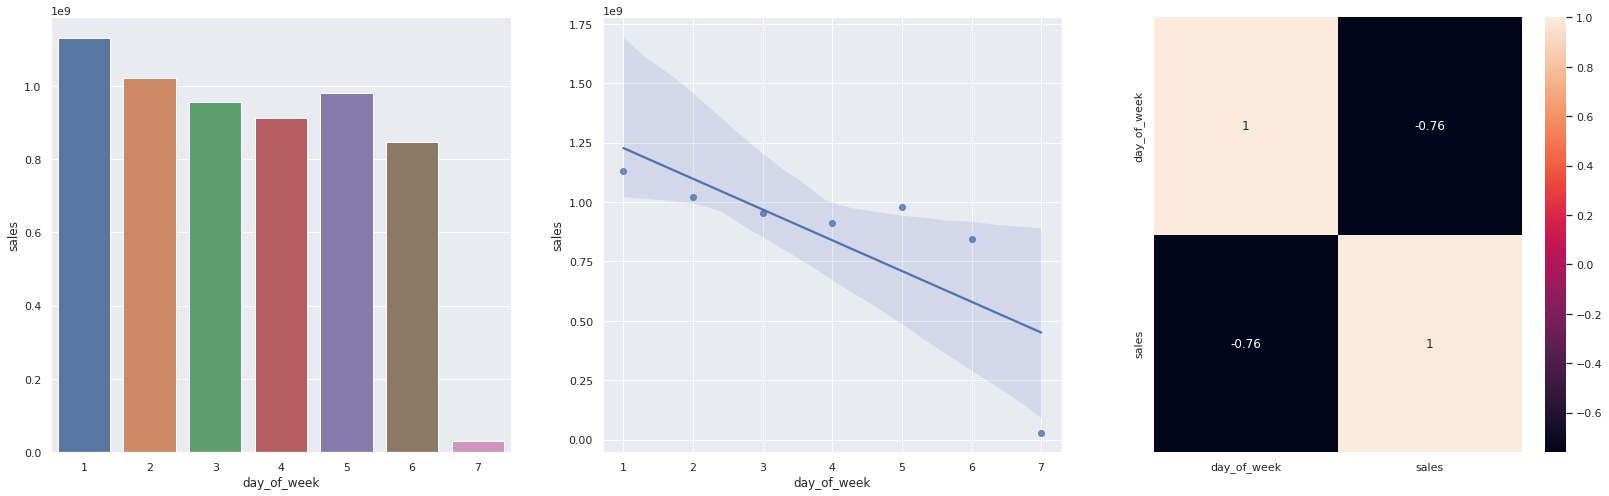

In [54]:
plt.subplot(1,3,1)
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data=aux, x='day_of_week', y='sales');

# tendência
plt.subplot(1,3,2)
sns.regplot(data=aux, x='day_of_week', y='sales');

# correlação
plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 10. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Resposta:** FALSA. Não vendem mais durante o Natal.

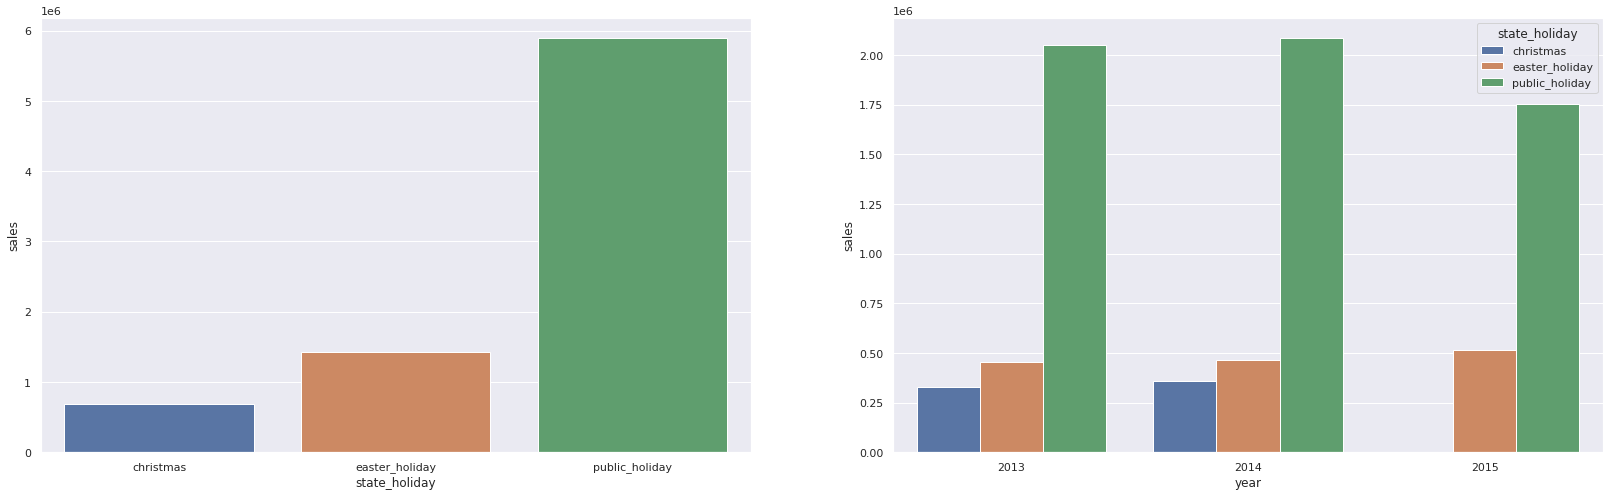

In [55]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales');

# vendas nos feriados ao longo do tempo
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year' ,'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales',hue='state_holiday');

### 11. Lojas deveriam vender mais ao longo dos anos.
**Resposta:** FALSA. As vendas estão caindo aos longos dos anos.

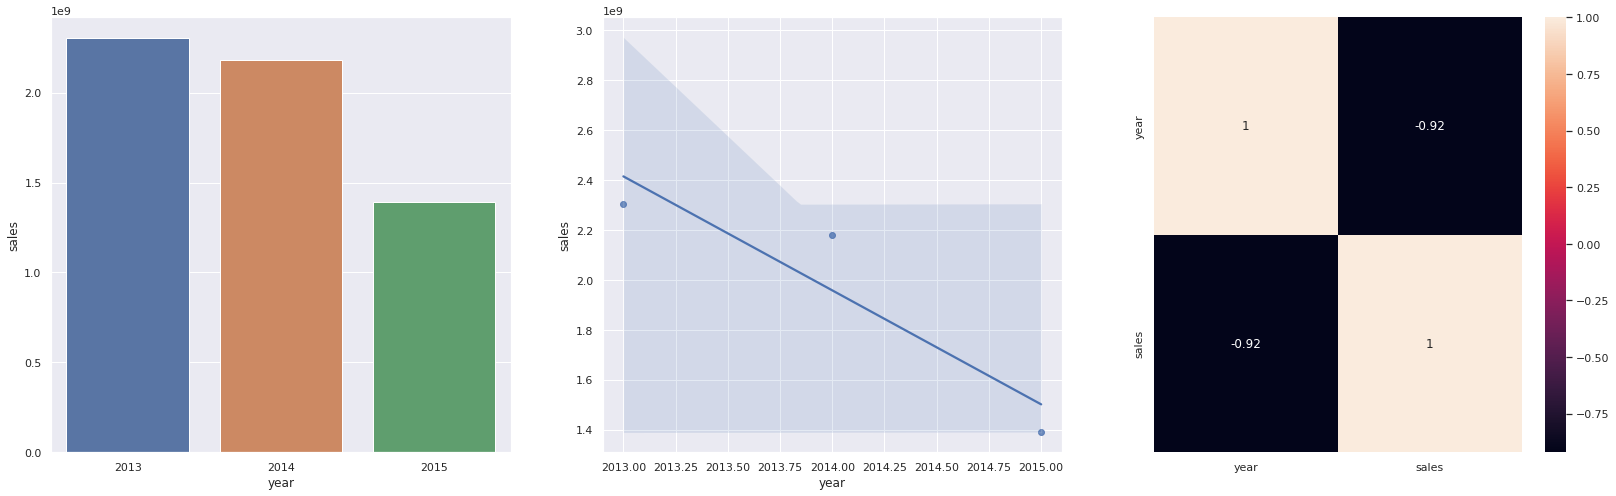

In [56]:
plt.subplot(1,3,1)
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(data=aux, x='year', y='sales');

# tendência
plt.subplot(1,3,2)
sns.regplot(data=aux, x='year', y='sales');

# correlação
plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

# tendência e correlação são muito fortes porque 2015 (o último ano do dataset) não está completo.
# sem o ano 2015 tendência e correlação ficam fracas

### 12. Lojas deveriam vender mais depois do dia 10.
**Resposta:** FALSA. Ao somar todos os 20 dias depois do dia 10, as lojas realmente vendem mais que nos 10 primeiros dias. Porém, ao considerar a média de vendas diárias em cada grupo (antes do dia 10 e depois do dia 10), verificamos que as lojas vendem menos depois do dia 10. É necessário usar a média diária de vendas para equilibrar a comparação entre 02 grupos de tamanhos distintos (antes e depois do dia 10). 

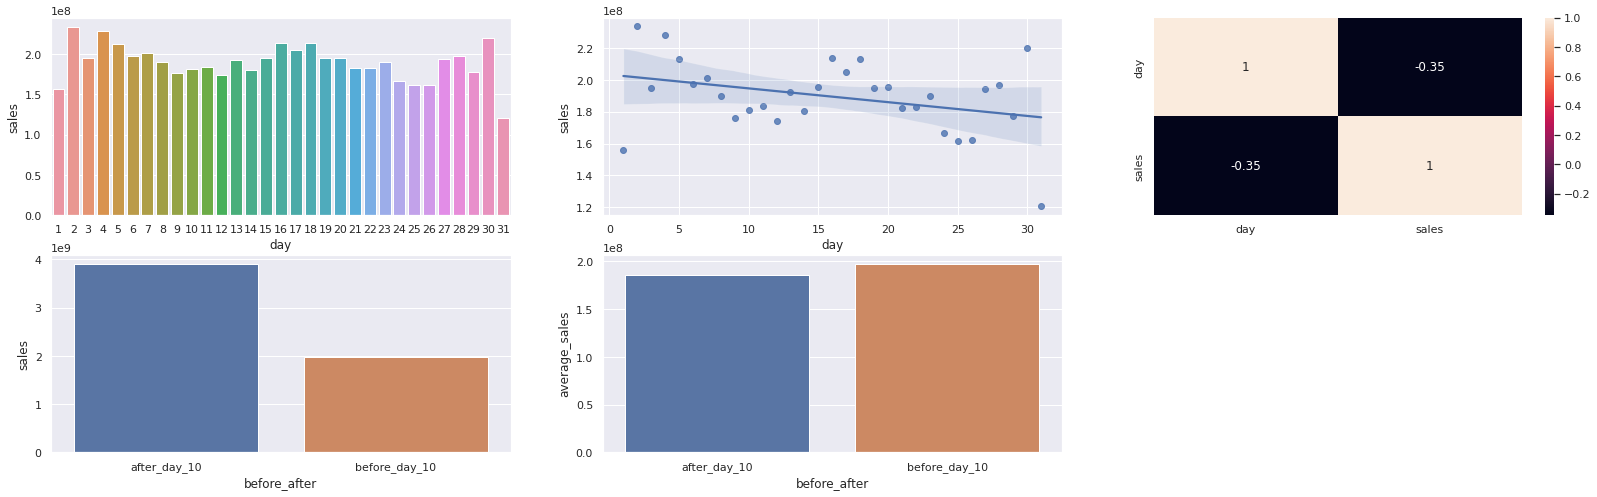

In [57]:
plt.subplot(2,3,1)
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(data=aux, x='day', y='sales');

# tendência
plt.subplot(2,3,2)
sns.regplot(data=aux, x='day', y='sales');

# correlação
plt.subplot(2,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True);

# o correto é dividir o dataset em 02 períodos: até o dia 10 e depois do dia 10
# e então comparar as vendas destes 02 períodos.
plt.subplot(2,3,4)
aux['before_after'] = aux['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux1, x='before_after', y='sales');

# mas existem MAIS DIAS depois do dia 10 que dias antes do dia 10
# logo, é provável que o grupo after somará mais que o grupo before
# o correto seria calcular as vendas médias por dia por grupo (before e after)
plt.subplot(2,3,5)
aux2 = aux[['before_after', 'sales']].groupby('before_after').mean().reset_index()
aux2 = aux2.rename(columns={'sales':'average_sales'})
sns.barplot(data=aux2, x='before_after', y='average_sales');

### 4.2.1. Resumo das Hipóteses

In [58]:
tab = [ ['Hipoteses', 'Conclusao', 'Relevancia'], 
        ['H1', 'Falsa', 'Média'],
        ['H2', 'Falsa', 'Alta'],
        ['H3', 'Falsa', 'Alta'],
        ['H4', 'Falsa', 'Média'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Alta'],
        ['H7', 'Falsa', 'Baixa'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Verdadeira', 'Alta'],
        ['H10', 'Falsa', 'Alta'],
        ['H11', 'Falsa', 'Baixa'],
        ['H12', 'Falsa', 'Média']
]

print (tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Média
H2           Falsa        Alta
H3           Falsa        Alta
H4           Falsa        Média
H5           -            -
H6           Falsa        Alta
H7           Falsa        Baixa
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Falsa        Alta
H11          Falsa        Baixa
H12          Falsa        Média


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot:>

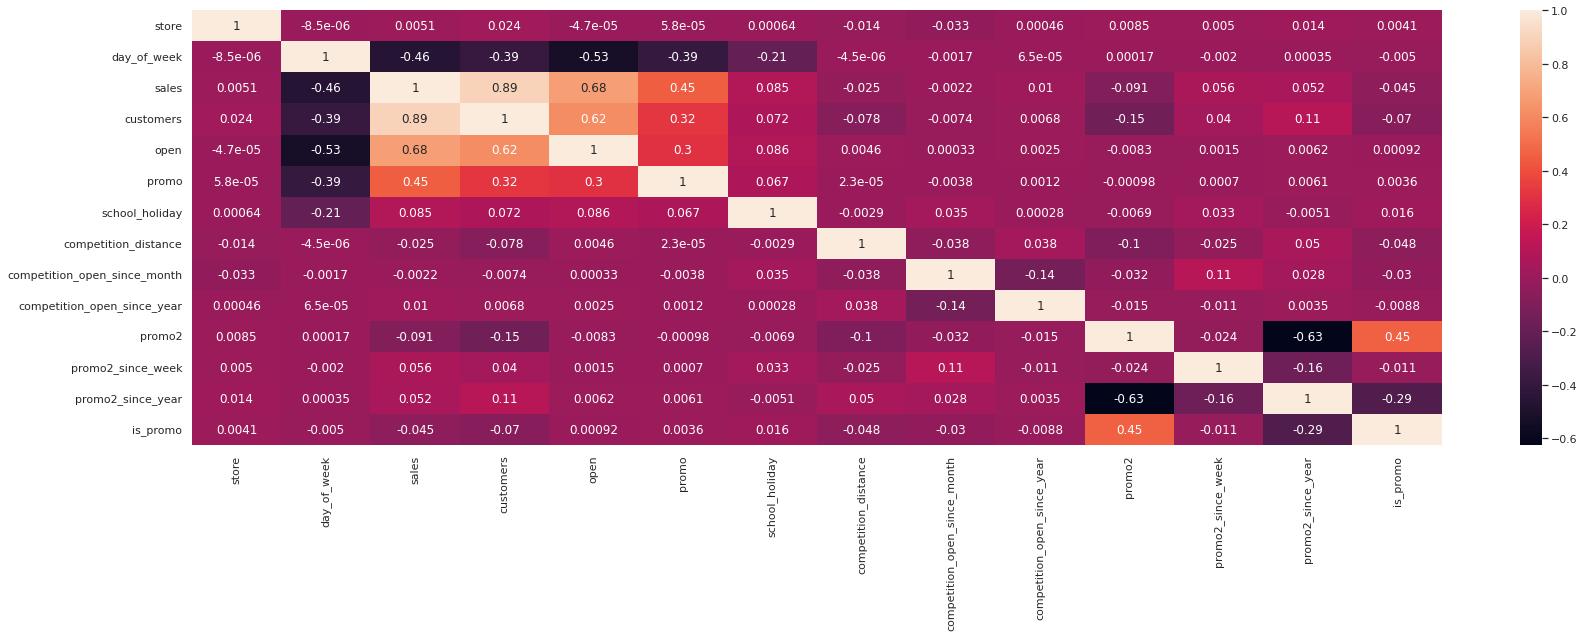

In [59]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

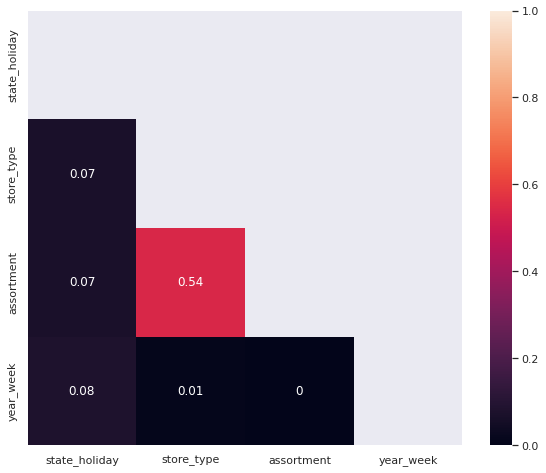

In [68]:
# 01 - Convert categorical values into numerical values.
# I'll use Label Encoding because all categories here have few values (eg 'Yes' or 'No')
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_attributes.columns:
  data_encoded[i]=label.fit_transform(cat_attributes[i])


# 02 - Perform Cramer's V test into each category then convert the results to dataframe.
cramers_results= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded: # perform cramer's V test two categories at a time
    cramers =cramers_v(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  cramers_results.append(col) # store test results
  
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns) # convert results (array) to dataframe

# plot heatmap
half_heatmap(df)

# 5. Preparação dos Dados

Procure variáveis com distribuições normais no passo 4.1.2 que tem os histogramas das variáveis numéricas.

In [70]:
df5 = df4.copy()

## 5.1. Standardization

Da análise das variáveis numéricas, não encontramos nenhuma com distribuição normal.

## 5.2. Rescaling

In [71]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [73]:
# se tem outlier: use robust-scaler. Se não, use min-max scaler
rs = RobustScaler()
mms = MinMaxScaler()

path = str(Path.cwd().parents[0] / "heroku_app" / "parameter")

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open(path + '/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open(path + '/year_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open(path + '/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open(path + '/promo_time_week_scaler.pkl', 'wb'))

# sns.boxplot(x=df5['year']); para ver se a distribuição tem outliers
# sns.displot(df5['competition_distance'], kind='kde', height=7, aspect=2); # para ver o resultado após rescaling

## 5.3. Transformação

### 5.3.1. Encoding

In [74]:
# state_holiday - One Hot Encoding
# é uma variável de estados: é feriado ou não é feriado
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
# não tem uma ordem entre elas
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(path + '/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
# existe uma ordem entre as variáveis: lojas com mais ou menos assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da Variável Resposta

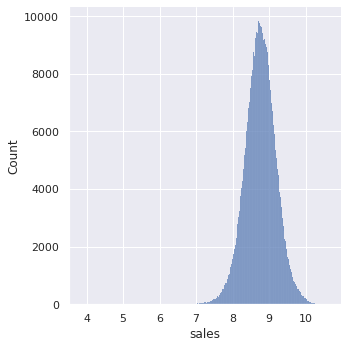

In [75]:
df5['sales'] = np.log1p(df5['sales'])
sns.displot(data = df5['sales']);

### 5.3.3. Transformação de Natureza

In [76]:
# variaveis com natureza cíclica:
# vamos implementar Transformação Seno-Cosseno

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7) ) )

# 6.0. Seleção de Atributos

In [78]:
df6 = df5.copy()

## 6.1. Dividindo o dataframe em dataset de treino e de teste

In [79]:
# as últimas 06 semanas do dataframe serão teste
# o período anterior será usado para treino

# primeira data do conjunto de treino - 02-01-2013
#df6[['store', 'date']].groupby('store').min().reset_index()

# última data do dataset - 31-07-2015
#df6[['store', 'date']].groupby('store').max().reset_index()

# qual a data 06 semanas antes da última do dataset? É 19-06-2015
# ou seja, de 02-01-2013 até 19-06-2015 é nosso conjunto de treino
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [80]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# testing dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# print('Training Min Date:{}'.format(x_train['date'].min()))
# print('Training Max Date:{}'.format(x_train['date'].max()))

# print('\nTesting Min Date:{}'.format(x_test['date'].min()))
# print('Testing Max Date:{}'.format(x_test['date'].max()))

## 6.2. Boruta como seletor de features

In [82]:
# training and testing dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-2, max_depth=6) 
# reduced max_depth and core usage to reduce execution time
# it took ~ 03 hours on Google Colab TPU

# define Boruta - it may take 5-30 hours and use all available memory
# original version:
# rf = RandomForestRegressor(n_jobs=-1)
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # features not selected by Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [83]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

Compare as variáveis selecionadas pelo Boruta com aquelas que você atribuiu relevância alta na análise exploratória. Se houver contradição, use a sugestão do Boruta neste primeiro ciclo de projeto. Use sua intuição para mesclar a sua seleção com a do Boruta.

# 7.0. Modelos de Machine Learning

In [84]:
x_train = X_train[cols_selected_boruta] # only relevant classes
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
cols_selected_boruta.extend(feat_to_add)

x_training = X_train[cols_selected_boruta_full] # relevant classes + date and sales

## 7.1. Modelo de Média

In [85]:
# creates training dataset with sales figures
train = x_train.copy() # training dataset without sales values
train['sales'] = y_train.copy() # training series with sales values

# testing dataset without sales values
test = x_test.copy()
test_sales = y_test.copy() 

# sales average per store on the training period
avg_sales_train = train[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'}) 

# forecast
forecast = pd.merge(test, avg_sales_train, how='left', on='store')
baseline = forecast['predictions'] # sales forecast series

# performance
baseline_result1 = ml_error('Average Model 1', np.expm1(test_sales), np.expm1(baseline)) # used exponential function because parameters were in log format
baseline_result1

,Model Name,MAE,MAPE,RMSE
0,Average Model 1,1429.763326,0.216814,1939.32873


## 7.2. Modelo de Regressão Linear

In [86]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [87]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE Cross-Validation,MAPE Cross-Validation,RMSE Cross-Validation
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3. Modelo de Linear Regression Regularized - Lasso

In [88]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso Linear Regression - Cross Validation

In [89]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE Cross-Validation,MAPE Cross-Validation,RMSE Cross-Validation
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4. Random Forest Regressor

In [90]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-2, random_state=42, max_depth=6).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1818.381168,0.273233,2606.352567


### 7.4.1. Random Forest Regressor - Cross Validation

In [91]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE Cross-Validation,MAPE Cross-Validation,RMSE Cross-Validation
0,Random Forest,2015.09+/-295.39,0.28+/-0.01,2862.77+/-431.14


## 7.5 XGBoost Regressor

In [94]:
# model
model_xgb = xgb.XGBRegressor(max_depth=6).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958204,0.130309,1238.550842


### 7.5.1. XGBoost Regressor - Cross Validation

In [95]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb)
xgb_result_cv

,Model Name,MAE Cross-Validation,MAPE Cross-Validation,RMSE Cross-Validation
0,XGBoost,1064.95+/-178.65,0.15+/-0.02,1519.92+/-242.12


## 7.6. Real Performance

In [96]:
modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_results_cv.sort_values('RMSE Cross-Validation')

,Model Name,MAE Cross-Validation,MAPE Cross-Validation,RMSE Cross-Validation
0,XGBoost,1064.95+/-178.65,0.15+/-0.02,1519.92+/-242.12
0,Random Forest,2015.09+/-295.39,0.28+/-0.01,2862.77+/-431.14
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


# 8. Hyperparameter Fine Tunning

## 8.1. Random Search

### 8.1.1. Random Search - Implementação real

In [ ]:
# param = {
#         'n_estimators': [100, 150, 200, 250, 300], 
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 5

In [ ]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # escolha os valores dos parâmetros aleatoriamente
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(
#                                 objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight']
#                                 )

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2 Modelo Final

In [97]:
# Recebe os parâmetros de melhor desempenho descobertos pelo Random Search
param_tuned = {
        'n_estimators': 300, 
        'eta': 0.03,
        'max_depth': 9,
        'subsample': 0.5,
        'colsample_bytree': 0.7,
        'min_child_weight': 3
        }

In [98]:
# model
model_xgb_tuned = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']
                            ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1036.558958,0.150497,1525.242086


### 8.2.1. Salvando o modelo treinado para não precisar treinar novamente

In [99]:
path = str(Path.cwd().parents[0] / "heroku_app" / "model")
path = path + '/' + 'model_rossman.pkl'

# saving model
pickle.dump(model_xgb_tuned, open(path, 'wb'))

# loading model
model_xgb_tuned = pickle.load(open(path, 'rb'))

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1036.558958,0.150497,1525.242086


In [100]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# 9. Performance

## 9.1. Business Performance

In [101]:
# sum of predictions
df9_sum_predictions = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE for every store
df9_mae = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_mape = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_pred_compare = pd.concat([df9_sum_predictions, df9_mae, df9_mape], axis=1,join='inner')
df9_pred_compare = df9_pred_compare.T.drop_duplicates().T

# scenarios
df9_pred_compare['worst_scenario'] = df9_pred_compare['predictions'] - df9_pred_compare['MAE']
df9_pred_compare['best_scenario'] = df9_pred_compare['predictions'] + df9_pred_compare['MAE']

# formatting and ordering columns
df9_pred_compare['store'] = df9_pred_compare['store'].astype('int64')
df9_pred_compare[['predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']] = df9_pred_compare[['predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']].round(2)
df9_pred_compare = df9_pred_compare[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [103]:
df9_pred_compare.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,178959.62,178484.10,179435.15,475.52,0.11
1,2,183190.50,182739.54,183641.46,450.96,0.09
2,3,249850.31,249326.07,250374.55,524.24,0.07
3,4,325861.38,324676.98,327045.77,1184.39,0.11
4,5,172942.55,172559.75,173325.34,382.80,0.09


     store  predictions  worst_scenario  best_scenario      MAE  MAPE
291    292    117073.70       113491.12      120656.27  3582.57  0.70
285    286    210617.78       208613.17      212622.40  2004.62  0.68
424    425    181092.47       179361.86      182823.08  1730.61  0.59
472    473    187151.19       185372.29      188930.08  1778.90  0.59
487    488    212798.52       210784.15      214812.88  2014.37  0.56
434    435    168308.73       166750.69      169866.78  1558.05  0.54
908    909    187540.84       178911.96      196169.73  8628.88  0.53
901    902    224927.73       222846.12      227009.35  2081.61  0.52
955    956    163562.56       162211.97      164913.15  1350.59  0.51
542    543    139367.28       138247.73      140486.83  1119.55  0.48


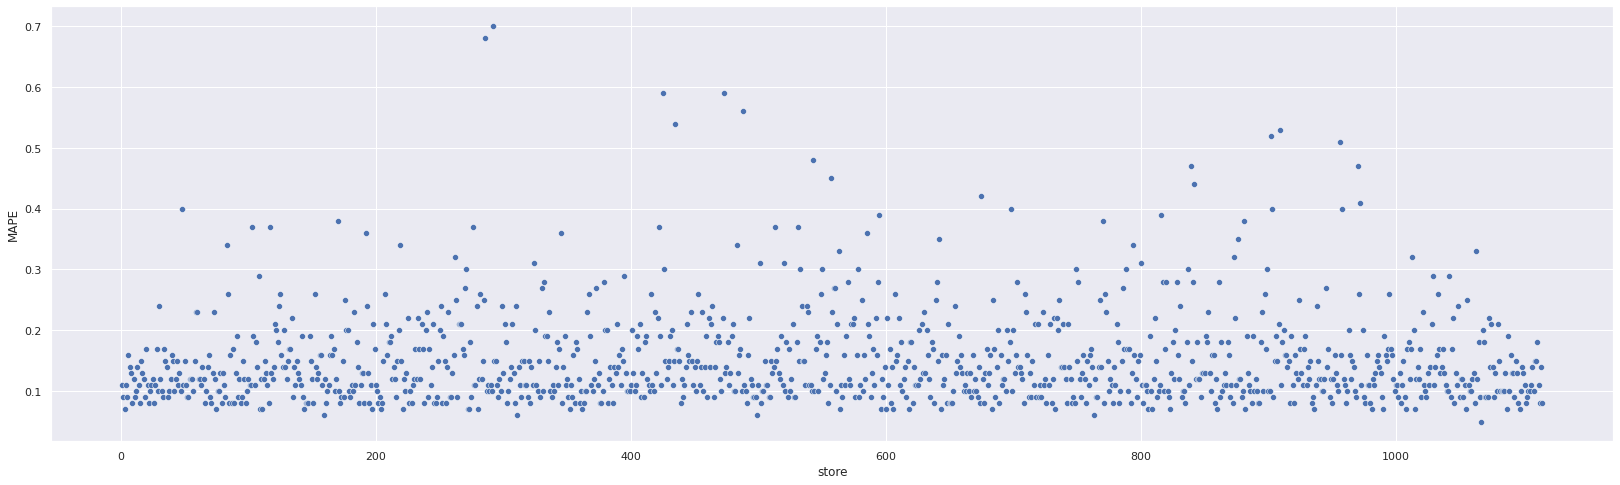

In [104]:
# most difficult stores to forecast sales
print(df9_pred_compare.sort_values('MAPE', ascending=False).head(10))
sns.scatterplot(x='store', y='MAPE', data=df9_pred_compare);

## 9.2. Total Performance

In [105]:
df9_pred_compare[['predictions', 'worst_scenario', 'best_scenario']].sum().map('R${:,.2f}'.format)

predictions       R$276,309,982.95
worst_scenario    R$275,152,071.81
best_scenario     R$277,467,894.10
dtype: object

## 9.3. Machine Learning Performance

In [106]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

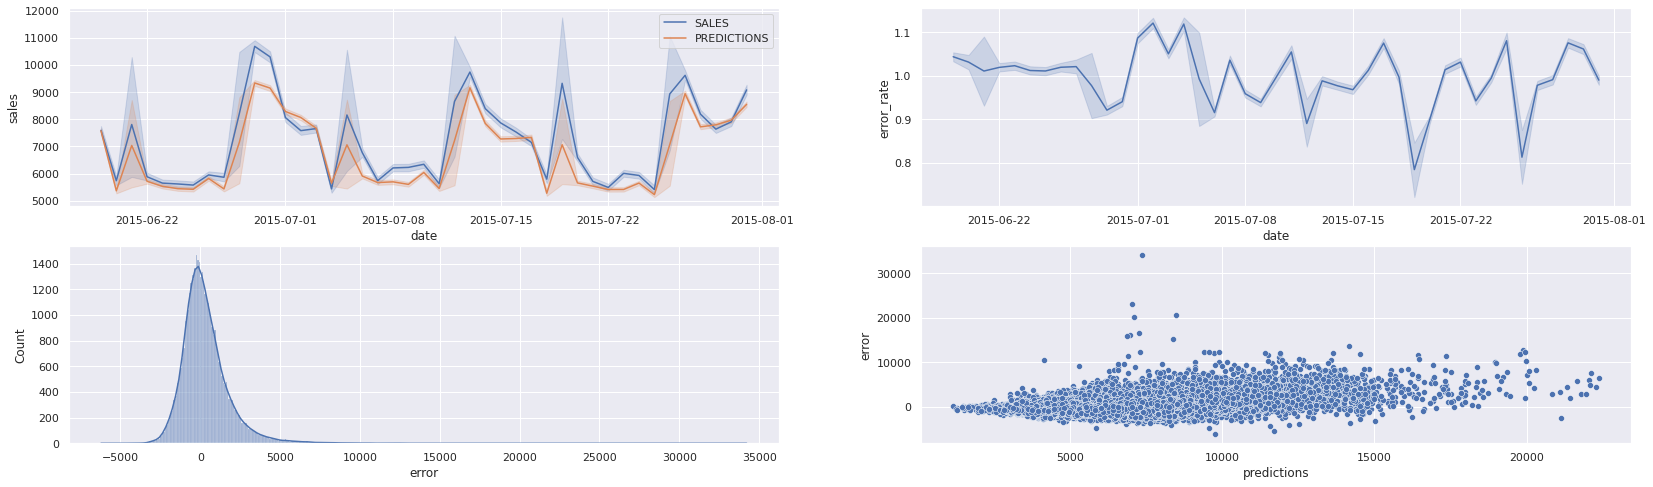

In [107]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.histplot(df9['error'], kde=True)

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9);

<AxesSubplot:xlabel='date', ylabel='sales'>

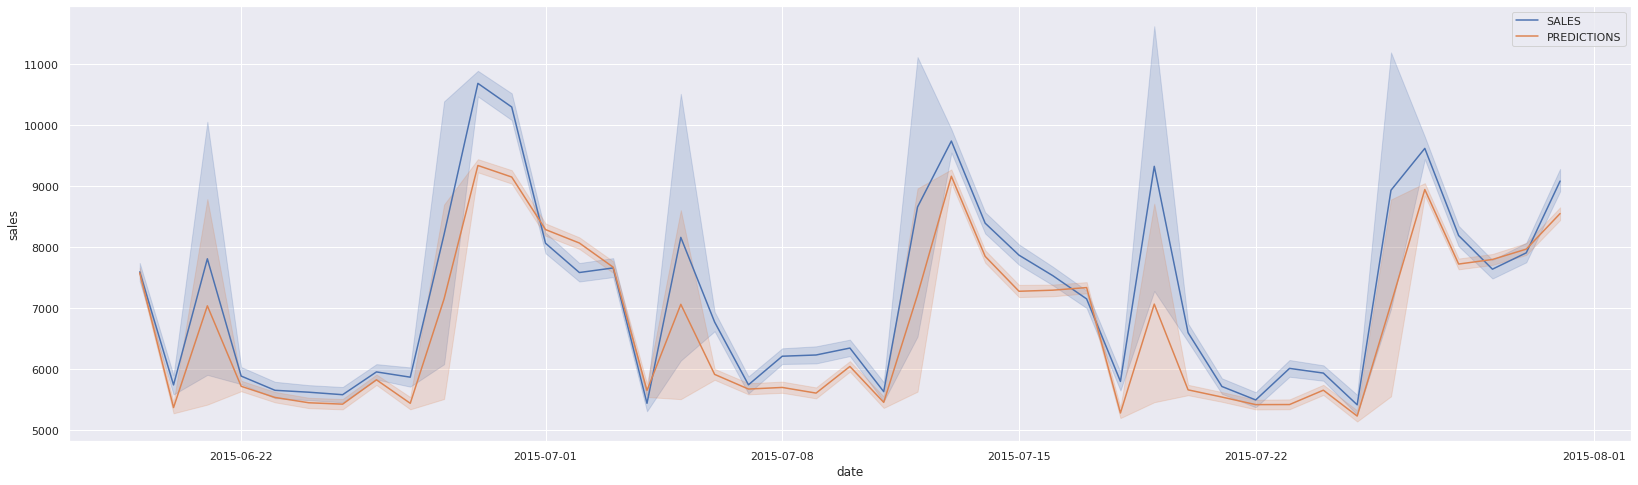

In [109]:
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')